In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models, Model
from sklearn.metrics import classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import shutil

In [29]:
version = tf.__version__
print("TensorFlow Version:", version)

TensorFlow Version: 2.9.1


In [ ]:
src_dirs = {
    'Earthquake': 'Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Earthquake',
    'Urban_Fire': 'Comprehensive Disaster Dataset(CDD)/Fire_Disaster/Urban_Fire',
    'Land_Slide': 'Comprehensive Disaster Dataset(CDD)/Land_Disaster/Land_Slide',
    'Water_Disaster': 'Comprehensive Disaster Dataset(CDD)/Water_Disaster'
}

target_root = 'dataset'

os.makedirs(target_root, exist_ok=True)

for class_name, src_dir in src_dirs.items():
    target_dir = os.path.join(target_root, class_name)
    os.makedirs(target_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(target_dir, fname)
        # Only copy image files
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                shutil.copy2(src_path, dst_path)
            except Exception as e:
                print(f"Could not copy {src_path}: {e}")

print("Dataset reorganized successfully!")

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    target_root,
    labels='inferred',
    label_mode='categorical', 
    image_size=(224, 224),     
    batch_size=32,
    shuffle=True
)

Found 1942 files belonging to 4 classes.


In [5]:
print(dataset.class_names)

['Earthquake', 'Land_Slide', 'Urban_Fire', 'Water_Disaster']


In [6]:
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)


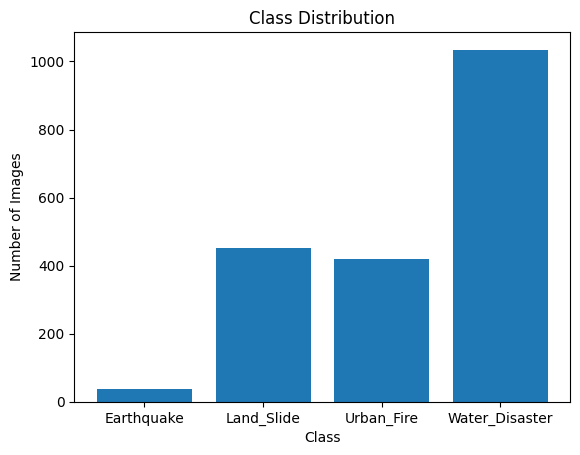

In [7]:
class_names = dataset.class_names
class_counts = {name: 0 for name in class_names}
for images, labels in dataset.unbatch():
    class_idx = np.argmax(labels.numpy())
    class_counts[class_names[class_idx]] += 1

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [8]:
img_size = (224, 224)
batch_size = 32
seed = 42

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    target_root,
    validation_split=0.3,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    target_root,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

Found 1942 files belonging to 4 classes.
Using 1360 files for training.
Found 1942 files belonging to 4 classes.
Using 582 files for validation.


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), 
    layers.RandomZoom(0.2),  
    layers.RandomContrast(0.2),  
    layers.RandomBrightness(0.2), 
    layers.RandomTranslation(0.1, 0.1), 
])
preprocessing = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (preprocessing(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds_prep = prepare(train_ds, augment=True)
val_ds_prep = prepare(val_ds)
test_ds_prep = prepare(test_ds)

In [11]:
for images, labels in train_ds_prep.take(1):
    print("Max pixel value:", images.numpy().max())
    print("Min pixel value:", images.numpy().min())
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Max pixel value: 1.0
Min pixel value: 0.0
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)


In [12]:
num_classes = len(class_names)

cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

In [13]:
cnn_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True)
]

history_cnn = cnn_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=20,
    callbacks = cnn_callbacks
)

Epoch 1/20
43/43 [==============================] - 14s 78ms/step - loss: 1.0270 - accuracy: 0.5603 - val_loss: 0.9412 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 5s 88ms/step - loss: 0.9549 - accuracy: 0.6118 - val_loss: 0.9534 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 3/20
43/43 [==============================] - 5s 90ms/step - loss: 0.9228 - accuracy: 0.6169 - val_loss: 0.9419 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 4/20
43/43 [==============================] - 5s 94ms/step - loss: 0.9232 - accuracy: 0.6221 - val_loss: 0.8533 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 5/20
43/43 [==============================] - 5s 92ms/step - loss: 0.8943 - accuracy: 0.6353 - val_loss: 0.8587 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 6/20
43/43 [==============================] - 5s 92ms/step - loss: 0.8874 - accuracy: 0.6279 - val_loss: 0.8673 - val_accuracy: 0.6497 - lr: 0.0010
Epoch 7/20
43/43 [==============================] - 5s 91ms/step - loss: 0.

In [14]:
cnn_model.save('final_cnn_model.keras')
print("CNN model saved!")

CNN model saved!


In [15]:
cnn_model.evaluate(test_ds_prep)

9/9 [==============================] - 1s 33ms/step - loss: 0.9141 - accuracy: 0.6944


[0.9141314029693604, 0.6944444179534912]

In [16]:
y_true_1 = []
y_pred_1 = []

for images, labels in train_ds_prep:
    preds = cnn_model.predict(images)
    y_true_1.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_1.extend(np.argmax(preds, axis=1))

y_true_2 = []
y_pred_2 = []

for images, labels in test_ds_prep:
    preds = cnn_model.predict(images)
    y_true_2.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_2.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 26ms/step


In [17]:
print("CNN Classification Report:")
print("Train Set:")
print(classification_report(y_true_1, y_pred_1, target_names=class_names, zero_division=0))
print("Test Set:")
print(classification_report(y_true_2, y_pred_2, target_names=class_names, zero_division=0))

CNN Classification Report:
Train Set:
                precision    recall  f1-score   support

    Earthquake       0.00      0.00      0.00        22
    Land_Slide       0.00      0.00      0.00       338
    Urban_Fire       0.83      0.59      0.69       290
Water_Disaster       0.60      0.97      0.74       710

      accuracy                           0.63      1360
     macro avg       0.36      0.39      0.36      1360
  weighted avg       0.49      0.63      0.53      1360

Test Set:
                precision    recall  f1-score   support

    Earthquake       0.00      0.00      0.00         8
    Land_Slide       0.00      0.00      0.00        59
    Urban_Fire       0.83      0.53      0.65        66
Water_Disaster       0.62      0.98      0.76       155

      accuracy                           0.65       288
     macro avg       0.36      0.38      0.35       288
  weighted avg       0.52      0.65      0.56       288



In [18]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
densenet_model = Model(inputs, outputs)

densenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

densenet_model.summary()

29084464/29084464 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                              

In [19]:
# Train the model
densenet_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('best_densenet_model.keras', monitor='val_accuracy', save_best_only=True)
]

history_densenet = densenet_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=15,
    callbacks = densenet_callbacks
)

Epoch 1/15
43/43 [==============================] - 16s 206ms/step - loss: 0.9492 - accuracy: 0.6228 - val_loss: 0.4998 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 2/15
43/43 [==============================] - 6s 125ms/step - loss: 0.6433 - accuracy: 0.7529 - val_loss: 0.4890 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 3/15
43/43 [==============================] - 6s 127ms/step - loss: 0.5890 - accuracy: 0.7860 - val_loss: 0.4455 - val_accuracy: 0.8231 - lr: 0.0010
Epoch 4/15
43/43 [==============================] - 6s 128ms/step - loss: 0.5280 - accuracy: 0.7978 - val_loss: 0.4361 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 5/15
43/43 [==============================] - 6s 132ms/step - loss: 0.4948 - accuracy: 0.8110 - val_loss: 0.3999 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 6/15
43/43 [==============================] - 6s 115ms/step - loss: 0.4558 - accuracy: 0.8176 - val_loss: 0.3900 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 7/15
43/43 [==============================] - 6s 122ms/step - l

In [20]:
densenet_model.save('densenet_before_finetuned.keras')

In [21]:
densenet_model.evaluate(test_ds_prep)

9/9 [==============================] - 1s 74ms/step - loss: 0.4087 - accuracy: 0.8715


[0.4086802303791046, 0.8715277910232544]

In [22]:
y_true_1 = []
y_pred_1 = []

for images, labels in train_ds_prep:
    preds = densenet_model.predict(images)
    y_true_1.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_1.extend(np.argmax(preds, axis=1))

y_true_2 = []
y_pred_2 = []

for images, labels in test_ds_prep:
    preds = densenet_model.predict(images)
    y_true_2.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_2.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 0s 33ms/step


In [23]:
print("DenseNet121 Before Fine Tuning Classification Report:")
print("Train Set:")
print(classification_report(y_true_1, y_pred_1, target_names=class_names, zero_division=0))
print("Test Set:")
print(classification_report(y_true_2, y_pred_2, target_names=class_names, zero_division=0))

DenseNet121 Before Fine Tuning Classification Report:
Train Set:
                precision    recall  f1-score   support

    Earthquake       0.43      0.27      0.33        22
    Land_Slide       0.81      0.82      0.82       338
    Urban_Fire       0.99      0.93      0.96       290
Water_Disaster       0.91      0.94      0.92       710

      accuracy                           0.90      1360
     macro avg       0.78      0.74      0.76      1360
  weighted avg       0.89      0.90      0.89      1360

Test Set:
                precision    recall  f1-score   support

    Earthquake       0.33      0.14      0.20         7
    Land_Slide       0.71      0.78      0.74        58
    Urban_Fire       0.94      0.79      0.86        61
Water_Disaster       0.89      0.94      0.92       162

      accuracy                           0.86       288
     macro avg       0.72      0.66      0.68       288
  weighted avg       0.85      0.86      0.85       288



In [24]:
base_model_2 = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model_2.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False


inputs = layers.Input(shape=(224, 224, 3))
x = base_model_2(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
densenet_model_2 = Model(inputs, outputs)

densenet_model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

densenet_model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0   

In [25]:
densenet_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('best_densenet_model.keras', monitor='val_accuracy', save_best_only=True)
]

history_densenet_2 = densenet_model_2.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=15,
    callbacks = densenet_callbacks
)

Epoch 1/15
43/43 [==============================] - 27s 376ms/step - loss: 1.3257 - accuracy: 0.4574 - val_loss: 56197340.0000 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 2/15
43/43 [==============================] - 13s 284ms/step - loss: 1.2079 - accuracy: 0.5176 - val_loss: 460.7950 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 3/15
43/43 [==============================] - 13s 283ms/step - loss: 1.0163 - accuracy: 0.5853 - val_loss: 808983.6875 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 4/15
43/43 [==============================] - 14s 303ms/step - loss: 1.0787 - accuracy: 0.5721 - val_loss: 2.3049 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 5/15
43/43 [==============================] - 13s 286ms/step - loss: 0.9870 - accuracy: 0.6029 - val_loss: 1.1321 - val_accuracy: 0.5646 - lr: 0.0010
Epoch 6/15
43/43 [==============================] - 13s 285ms/step - loss: 1.0312 - accuracy: 0.5816 - val_loss: 2.6602 - val_accuracy: 0.2517 - lr: 0.0010
Epoch 7/15
43/43 [==============================] 

In [26]:
densenet_model.save('final_densenet_model.keras')

In [27]:
densenet_model.evaluate(test_ds_prep)

y_true_1 = []
y_pred_1 = []

for images, labels in train_ds_prep:
    preds = densenet_model.predict(images, verbose=0)
    y_true_1.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_1.extend(np.argmax(preds, axis=1))

y_true_2 = []
y_pred_2 = []

for images, labels in test_ds_prep:
    preds = densenet_model.predict(images, verbose=0)
    y_true_2.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_2.extend(np.argmax(preds, axis=1))


9/9 [==============================] - 1s 76ms/step - loss: 0.4602 - accuracy: 0.8646


In [28]:
print("DenseNet121 Classification Report:")
print("Train Set:")
print(classification_report(y_true_1, y_pred_1, target_names=class_names, zero_division=0))
print("Test Set:")
print(classification_report(y_true_2, y_pred_2, target_names=class_names, zero_division=0))

import json
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved!")

DenseNet121 Classification Report:
Train Set:
                precision    recall  f1-score   support

    Earthquake       0.50      0.32      0.39        22
    Land_Slide       0.84      0.83      0.83       338
    Urban_Fire       0.97      0.93      0.95       290
Water_Disaster       0.92      0.95      0.93       710

      accuracy                           0.90      1360
     macro avg       0.81      0.76      0.78      1360
  weighted avg       0.90      0.90      0.90      1360

Test Set:
                precision    recall  f1-score   support

    Earthquake       0.00      0.00      0.00         4
    Land_Slide       0.75      0.81      0.78        57
    Urban_Fire       0.94      0.84      0.89        58
Water_Disaster       0.91      0.94      0.93       169

      accuracy                           0.88       288
     macro avg       0.65      0.65      0.65       288
  weighted avg       0.88      0.88      0.88       288

Class names saved!


In [31]:
import tensorflow as tf

model = tf.keras.models.load_model('final_densenet_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("densenet.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp6qdxmjpp\assets


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp6qdxmjpp\assets
